In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, LSTM, SpatialDropout1D
from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Dropout
import re

In [2]:
stopwords=["i", "me", "my", "myself", "we", "our", "ours", "ourselves", "you", "your", "yours",
           "yourself", "yourselves", "he", "him", "his", "himself", "she", "her", "hers", "herself",
           "it", "its", "itself", "they", "them", "their", "theirs", "themselves", "what", "which",
           "who", "whom", "this", "that", "these", "those", "am", "is", "are", "was", "were", "be",
           "been", "being", "have", "has", "had", "having", "do", "does", "did", "doing", "a", "an",
           "the", "and", "but", "if", "or", "because", "as", "until", "while", "of", "at", "by",
           "for", "with", "about", "against", "between", "into", "through", "during", "before",
           "after", "above", "below", "to", "from", "up", "down", "in", "out", "on", "off", "over",
           "under", "again", "further", "then", "once", "here", "there", "when", "where", "why",
           "how", "all", "any", "both", "each", "few", "more", "most", "other", "some", "such",
           "no", "nor", "not", "only", "own", "same", "so", "than", "too", "very", "s", "t", "can",
           "will", "just", "don", "should", "now"]
STOPWORDS = set(stopwords)

In [3]:
df=pd.read_csv('C:/Users/Zephyrus/Datasets/NLP/subjects-questions.csv')

In [4]:
df.head()

,eng,Subject
0,An anti-forest measure is\nA. Afforestation\nB...,Biology
1,"Among the following organic acids, the acid pr...",Chemistry
2,If the area of two similar triangles are equal...,Maths
3,"In recent year, there has been a growing\nconc...",Biology
4,Which of the following statement\nregarding tr...,Physics


In [5]:
df['eng'][456]

'The area of triangle formed by the lines\n\\( 18 x^{2}-9 x y+y^{2}=0 \\) and the line \\( y=9 \\)\nis\nA. \\( \\frac{27}{4} \\)\nв. \\( \\frac{27}{2} \\)\nc. \\( \\frac{27}{8} \\)\nD. 27'

In [6]:
df = df.reset_index(drop=True)
REPLACE_BY_SPACE_RE = re.compile('[/(){}\[\]\|@,;]')
BAD_SYMBOLS_RE = re.compile('[^0-9a-z #+_]')

def clean_text(text):
    text = text.lower()
    text = REPLACE_BY_SPACE_RE.sub(' ', text)
    text = BAD_SYMBOLS_RE.sub('', text) 
    text = text.replace('x', '')
    text = ' '.join(word for word in text.split() if word not in STOPWORDS)
    return text
df['eng'] = df['eng'].apply(clean_text)

In [7]:
df['eng'][456]

'area triangle formed lines 18 2 9 y+y 2 0 line y9 isa frac 27 4 frac 27 2 c frac 27 8 d 27'

In [8]:
MAX_NB_WORDS = 10000
MAX_SEQUENCE_LENGTH = 100
EMBEDDING_DIM = 100

tokenizer = Tokenizer(num_words=MAX_NB_WORDS, filters='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~', lower=True)
tokenizer.fit_on_texts(df['eng'].values)
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

Found 136535 unique tokens.


In [9]:
X = tokenizer.texts_to_sequences(df['eng'].values)
X = pad_sequences(X, maxlen=MAX_SEQUENCE_LENGTH)
print('Shape of data tensor:', X.shape)

Shape of data tensor: (122519, 100)


In [10]:
type(X)

numpy.ndarray

In [11]:
from sklearn.preprocessing import LabelEncoder
lb=LabelEncoder()
Y=lb.fit_transform(df['Subject']) 
print('Shape of label tensor 1:', Y.shape)

Shape of label tensor 1: (122519,)


In [12]:
X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size = 0.2)
print(X_train.shape,Y_train.shape)
print(X_test.shape,Y_test.shape)

(98015, 100) (98015,)
(24504, 100) (24504,)


In [13]:
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint

es=EarlyStopping(monitor='val_accuracy', mode='max', verbose=1, patience=3)
mc=ModelCheckpoint('best_model.h5', monitor='val_accuracy', mode=max, verbose=1, save_best_only=True)

In [14]:
model = Sequential()
model.add(Embedding(MAX_NB_WORDS, EMBEDDING_DIM, input_length=X.shape[1]))
model.add(SpatialDropout1D(0.2))
model.add(LSTM(100, recurrent_regularizer='l2'))
model.add(Dropout(0.4))
model.add(Dense(16, kernel_regularizer='l1', activation='relu'))
model.add(Dropout(0.4))
model.add(Dense(4, activation='softmax'))
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 100, 100)          1000000   
                                                                 
 spatial_dropout1d (SpatialD  (None, 100, 100)         0         
 ropout1D)                                                       
                                                                 
 lstm (LSTM)                 (None, 100)               80400     
                                                                 
 dropout (Dropout)           (None, 100)               0         
                                                                 
 dense (Dense)               (None, 16)                1616      
                                                                 
 dropout_1 (Dropout)         (None, 16)                0         
                                                        

In [15]:
epochs = 10
batch_size = 64

history = model.fit(X_train, Y_train, epochs=epochs, batch_size=batch_size,validation_split=0.2, callbacks=[mc])

Epoch 1/10
1225/1226 [============================>.] - ETA: 0s - loss: 1.0245 - accuracy: 0.7336
Epoch 1: val_accuracy improved from -inf to 0.89165, saving model to best_model.h5
1226/1226 [==============================] - 31s 23ms/step - loss: 1.0244 - accuracy: 0.7336 - val_loss: 0.5462 - val_accuracy: 0.8916
Epoch 2/10
1225/1226 [============================>.] - ETA: 0s - loss: 0.5576 - accuracy: 0.8810
Epoch 2: val_accuracy improved from 0.89165 to 0.90185, saving model to best_model.h5
1226/1226 [==============================] - 28s 23ms/step - loss: 0.5575 - accuracy: 0.8811 - val_loss: 0.4256 - val_accuracy: 0.9019
Epoch 3/10
1225/1226 [============================>.] - ETA: 0s - loss: 0.4931 - accuracy: 0.8967
Epoch 3: val_accuracy improved from 0.90185 to 0.90945, saving model to best_model.h5
1226/1226 [==============================] - 28s 23ms/step - loss: 0.4931 - accuracy: 0.8967 - val_loss: 0.4085 - val_accuracy: 0.9095
Epoch 4/10
1225/1226 [========================

In [16]:
acc=max(history.history['val_accuracy'])
print(acc*100,'%')

91.44008755683899 %


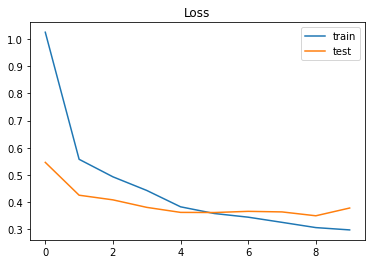

In [17]:
plt.title('Loss')
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show();

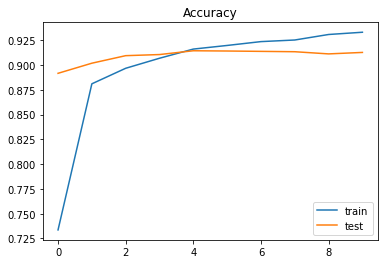

In [18]:
plt.title('Accuracy')
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='test')
plt.legend()
plt.show();

In [19]:
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1
